# Audiovisual Annotation Analysis for Naturalistic Stimulation Dataset

This notebook analyzes the temporal and semantic relationships in audiovisual annotations from a naturalistic stimulation experiment. The data comes from the paper "Open multimodal iEEG-fMRI dataset from naturalistic stimulation with a short audiovisual film".

## Dataset Overview
- Sound annotations: phonemes, words, sentences, and speaker-specific annotations
- Video annotations: various entities, actions, and visual elements appearing in the video
- Temporal information: Start and end times for each annotation

## Analysis Goals
1. Temporal patterns in audiovisual events
2. Entity co-occurrences and relationships
3. Cross-modal correlations between audio and visual elements
4. Statistical analysis of annotation distributions
5. Event timing and synchronization patterns

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from scipy import stats
import networkx as nx
from itertools import combinations

# Set plot style
sns.set_theme(style="whitegrid", palette="husl")
# Utility function to load TSV files
def load_tsv_files(directory):
    """Load all TSV files from a directory into a dictionary of dataframes"""
    tsv_files = glob.glob(str(Path(directory) / "*.tsv"))
    data_dict = {}
    
    for file_path in tsv_files:
        name = Path(file_path).stem.replace("sound_annotation_", "").replace("video_annotation_", "")
        df = pd.read_csv(file_path, sep='\t')
        data_dict[name] = df
    
    return data_dict

# Directory paths
SOUND_DIR = "/home/dbalu/cs/neuroinformatics/project_data/sound"
VIDEO_DIR = "/home/dbalu/cs/neuroinformatics/project_data/video"

# Load data
sound_data = load_tsv_files(SOUND_DIR)
video_data = load_tsv_files(VIDEO_DIR)

## 1. Data Exploration and Initial Analysis

Let's examine the structure of our annotations and create some initial visualizations to understand the temporal distribution of events.

In [8]:
# Let's first examine what kind of annotations we have
print("Sound Annotations:")
for key, df in sound_data.items():
    print(f"{key}: {len(df)} annotations")
    
print("\nVideo Annotations:")
for key, df in video_data.items():
    print(f"{key}: {len(df)} annotations")

# Let's check the structure of one sound and one video annotation file
print("\nSound annotation structure (words):")
print(sound_data['words'].head())

print("\nVideo annotation structure (face):")
print(video_data['face'].head())

Sound Annotations:
questions: 15 annotations
konrad: 194 annotations
words: 446 annotations
phonemes: 1456 annotations
mom: 39 annotations
verbs: 109 annotations
sentences: 67 annotations
tommi: 57 annotations
dad: 4 annotations
annika: 49 annotations
pippi: 118 annotations
syllables: 611 annotations
clauses: 92 annotations

Video Annotations:
door: 13 annotations
building: 7 annotations
performance: 1 annotations
nature: 4 annotations
dad: 1 annotations
body: 16 annotations
table: 11 annotations
couple: 15 annotations
pavement: 2 annotations
mustache: 14 annotations
hand: 19 annotations
togetherness: 8 annotations
fox: 1 annotations
rainforest: 2 annotations
dancer: 3 annotations
exploration: 4 annotations
woman: 23 annotations
amphibian: 1 annotations
dance: 3 annotations
countryside: 4 annotations
walk: 14 annotations
lunch: 2 annotations
domestic: 6 annotations
summer: 4 annotations
ballet: 3 annotations
ground: 9 annotations
band: 1 annotations
grass: 11 annotations
hair: 22 annot

## 2. Temporal Analysis of Events

Let's analyze the temporal distribution of different types of events and create visualizations to understand:
1. Event density over time
2. Overlapping events
3. Temporal patterns between different annotation types

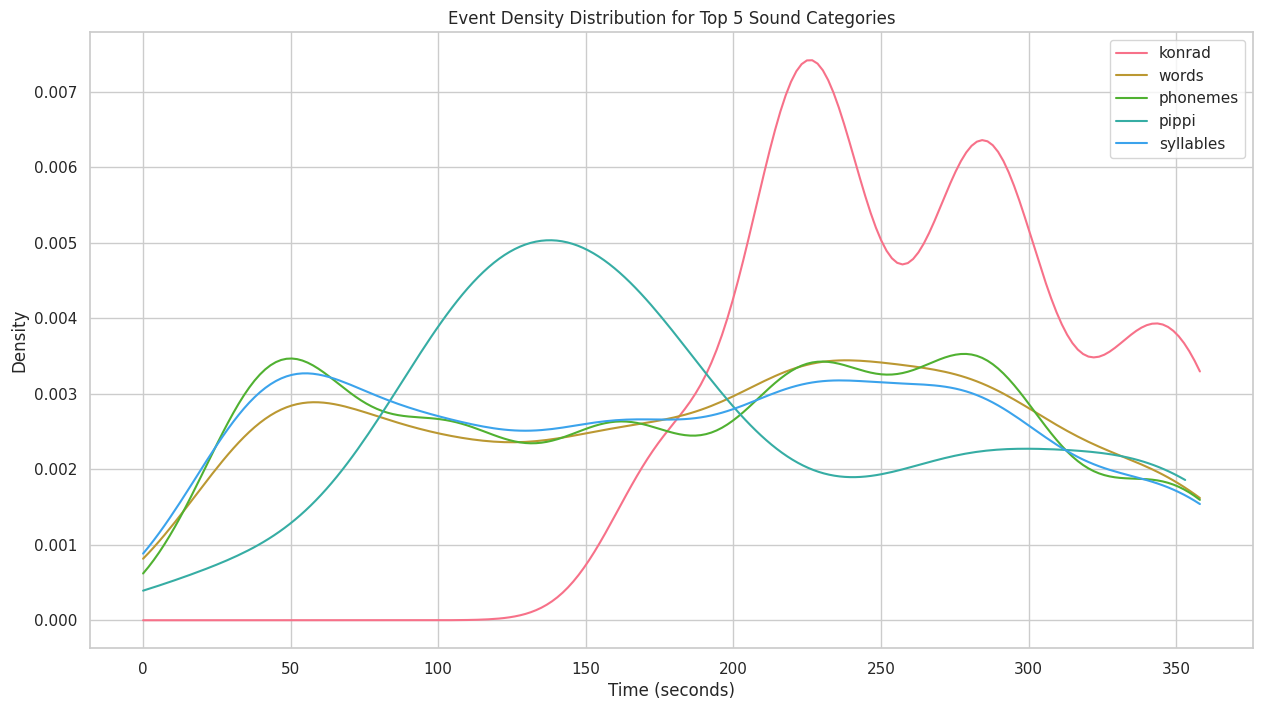

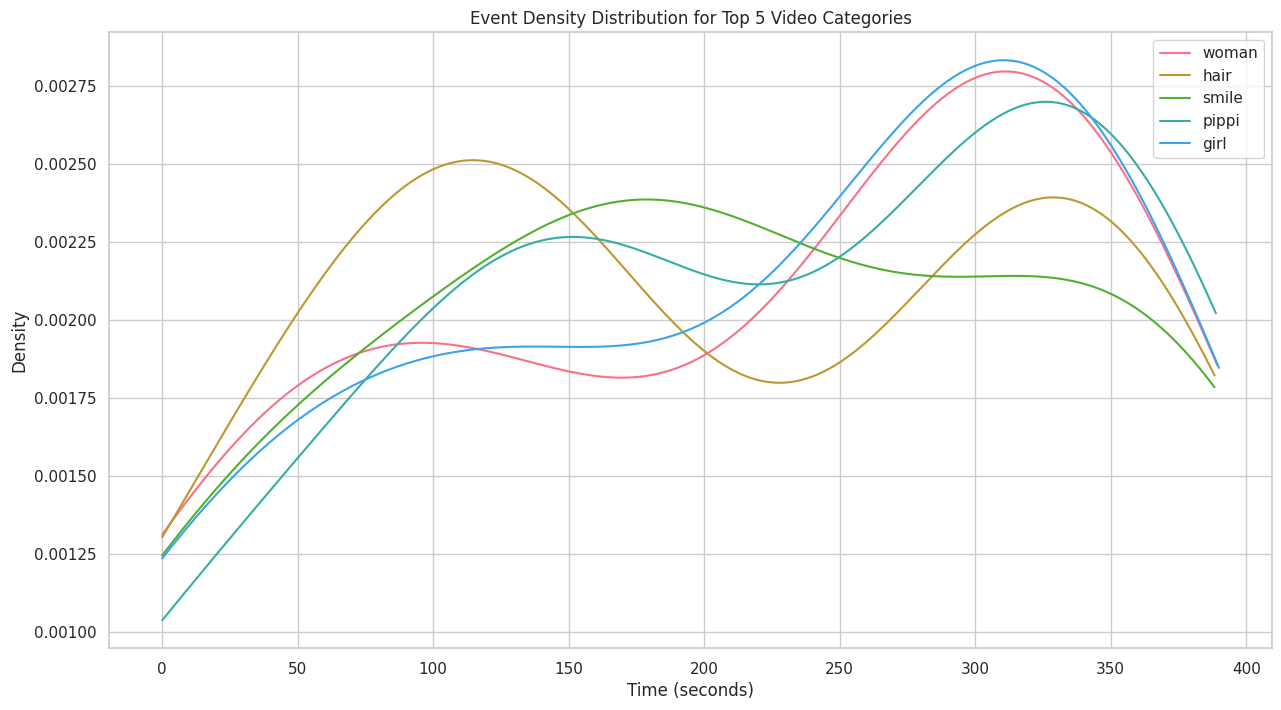

In [9]:
# Function to create event density plot
def plot_event_density(data_dict, category_type='sound', num_categories=5):
    plt.figure(figsize=(15, 8))
    
    # Get the most frequent categories
    all_lengths = {k: len(v) for k, v in data_dict.items()}
    top_categories = dict(sorted(all_lengths.items(), key=lambda x: x[1], reverse=True)[:num_categories])
    
    for name, df in data_dict.items():
        if name in top_categories:
            # Create event density using start times
            kde = stats.gaussian_kde(df['onset'])
            x_range = np.linspace(0, df['offset'].max(), 200)
            plt.plot(x_range, kde(x_range), label=name)
    
    plt.title(f'Event Density Distribution for Top {num_categories} {category_type.capitalize()} Categories')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot event density for sound and video annotations
plot_event_density(sound_data, 'sound')
plot_event_density(video_data, 'video')

## 3. Cross-Modal Analysis

Now let's analyze the relationships between audio and visual events to identify interesting patterns and correlations.

Event counts per category:
places: 74
other: 491
people: 169
objects: 57
activities: 58
animals: 55
nature: 61
emotions: 74


/tmp/ipykernel_3557037/1041288374.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="husl")


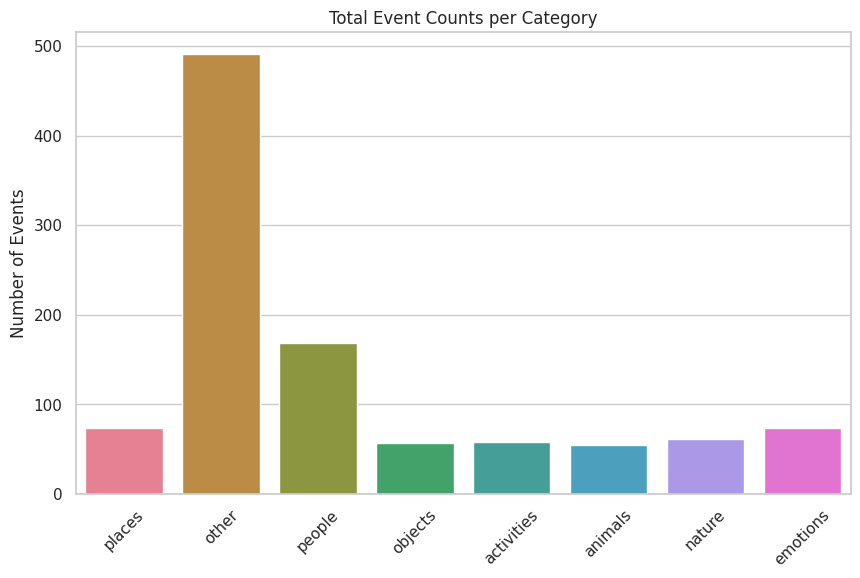

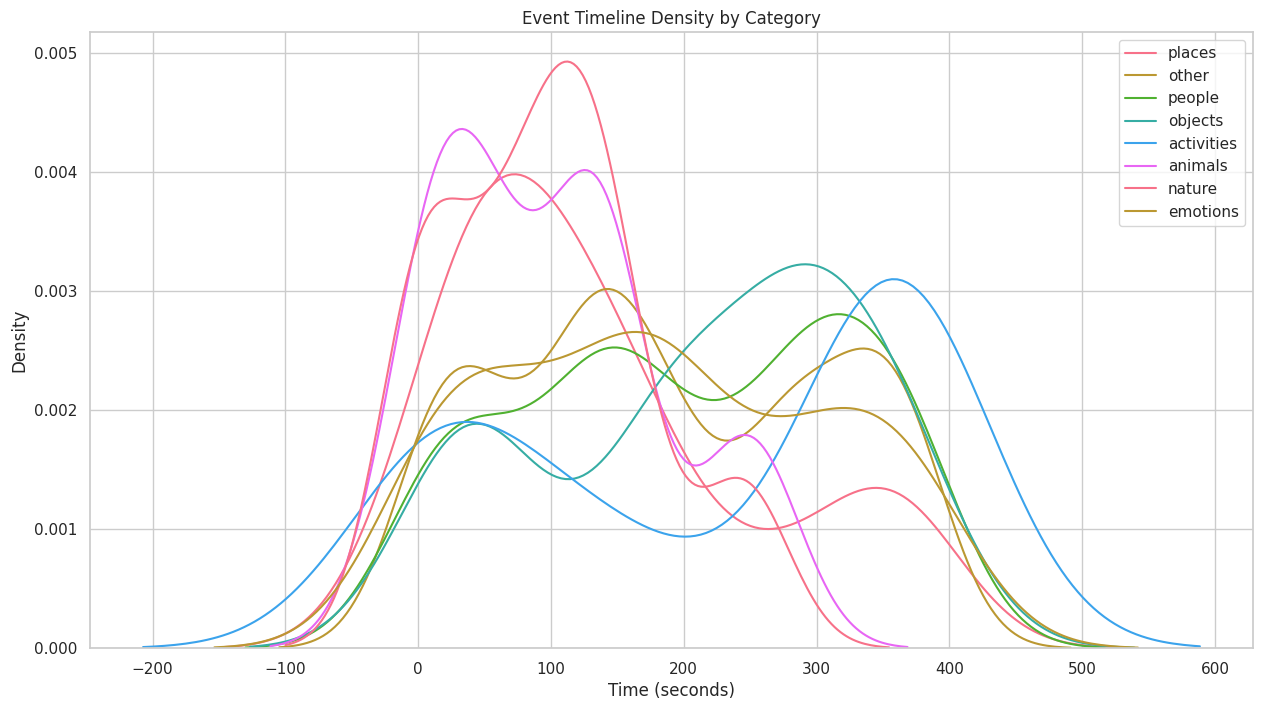

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from collections import defaultdict

sns.set_theme(style="whitegrid", palette="husl")

# ---- CATEGORIES ----
CATEGORY_MAP = {
    "people": ["man","woman","child","boy","girl","adult","mom","dad", "person","people","adolescent"],
    "animals": ["dog","cat","horse","stallion","pony","equine","equestrian",
                "owl","frog","reptile","amphibian","rodent","wildlife",
                "animal","mammal"],
    "objects": ["chair","table","furniture","cap","hat","candle","food","meal",
                "drink","lunch"],
    "nature": ["tree","forest","field","grass","sky","storm","summer","daylight",
               "rain","environment","outdoors","rural","countryside","farm",
               "farming","agriculture"],
    "places": ["architecture","house","building","facade","room","concert",
               "performance","restaurant","street","park","pavement","road",
               "window","door","bench","roof"],
    "activities": ["dance","dancing","dancer","ballet","ballerina","concert",
                   "music","run","climb","transportation","travel","sport",
                   "agility","acrobatics"],
    "emotions": ["smile","happiness","enjoyment","fun","facial expression"]
}

def categorize_annotations(video_data):
    """Map each TSV (by name) into a high-level category."""
    categorized = defaultdict(list)
    for name, df in video_data.items():
        for cat, keywords in CATEGORY_MAP.items():
            if name.lower() in keywords:
                categorized[cat].append((name, df))
                break
        else:
            categorized["other"].append((name, df))
    return categorized

# ---- ANALYSIS ----
def analyze_categories(categorized):
    counts = {cat: sum(len(df) for _, df in items) for cat, items in categorized.items()}
    return counts

def plot_category_counts(counts):
    plt.figure(figsize=(10,6))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="husl")
    plt.title("Total Event Counts per Category")
    plt.xticks(rotation=45)
    plt.ylabel("Number of Events")
    plt.show()

def plot_category_timeline(categorized, total_duration=600):
    """Overlay KDE plots for each category across video timeline"""
    plt.figure(figsize=(15,8))
    for cat, items in categorized.items():
        all_onsets = []
        for _, df in items:
            all_onsets.extend(df["onset"].tolist())
        if len(all_onsets) > 0:
            sns.kdeplot(all_onsets, label=cat, fill=False)
    plt.title("Event Timeline Density by Category")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# ---- RUN ----
categorized = categorize_annotations(video_data)
counts = analyze_categories(categorized)

print("Event counts per category:")
for k, v in counts.items():
    print(f"{k}: {v}")

# Plots
plot_category_counts(counts)
plot_category_timeline(categorized)


In [11]:
for name, df in categorized['other']:
    print(f"Category: {name}, Number of events: {len(df)}")
    print(df.head())
    print("\n")
print(categorized['other'])

Category: nature, Number of events: 4
    onset  offset
0    0.00   66.40
1   81.88  113.36
2  120.00  170.68
3  239.96  265.80


Category: body, Number of events: 16
   onset  offset
0   0.00    6.24
1   9.40   16.60
2  20.40   27.96
3  29.56   47.12
4  51.32   60.08


Category: couple, Number of events: 15
    onset  offset
0    0.00    6.24
1    9.40   16.60
2   20.40   27.08
3   51.32   60.08
4  118.08  119.96


Category: mustache, Number of events: 14
    onset  offset
0  171.52  180.08
1  184.32  192.00
2  194.72  211.72
3  214.60  218.36
4  228.48  236.60


Category: hand, Number of events: 19
    onset  offset
0    0.00    6.24
1   29.56   47.12
2   51.32   60.08
3  140.48  143.20
4  175.52  180.08


Category: togetherness, Number of events: 8
    onset  offset
0   30.44   31.88
1   35.20   47.12
2   90.00  106.52
3  107.40  109.44
4  113.40  118.12


Category: fox, Number of events: 1
    onset  offset
0  254.64  257.16


Category: rainforest, Number of events: 2
    onset  of

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def people_time_series(video_data, total_duration=None, fps=1):
    # Collect all people-related events
    people_keywords = set(CATEGORY_MAP["people"])
    people_dfs = [df for name, df in video_data.items() if name.lower() in people_keywords]

    if not people_dfs:
        print("No people annotations found.")
        return None
    
    # Estimate total duration from max offset if not given
    if total_duration is None:
        total_duration = max(df['offset'].max() for df in people_dfs)
    
    # Discretize into per-second bins
    timeline = np.zeros(int(np.ceil(total_duration))+2)
    
    for df in people_dfs:
        for _, row in df.iterrows():
            start = int(np.floor(row['onset']))
            end = int(np.ceil(row['offset']))
            timeline[start:end+1] += 1   # increment count of people
    
    return timeline

# ---- RUN ----
people_counts = people_time_series(video_data)

pdf_path = "people_time_series_plot.pdf"

if people_counts is not None:
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(15,6))
        plt.plot(np.arange(len(people_counts)), people_counts, color="blue", lw=2)
        plt.title("Number of People Events per Second", fontsize=20)
        plt.xlabel("Time (s)", fontsize=16)
        plt.ylabel("Number of People Present \n (Window size 2secs)", fontsize=16)
        plt.grid(True)
        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

    summary_stats = {
        "Peak number of people events": int(people_counts.max()),
        "Average number of people per second": float(people_counts.mean()),
        "Total duration with people present": int((people_counts>0).sum())
    }
else:
    summary_stats = {}

pdf_path, summary_stats


('people_time_series_plot.pdf',
 {'Peak number of people events': 13,
  'Average number of people per second': 6.229591836734694,
  'Total duration with people present': 354})

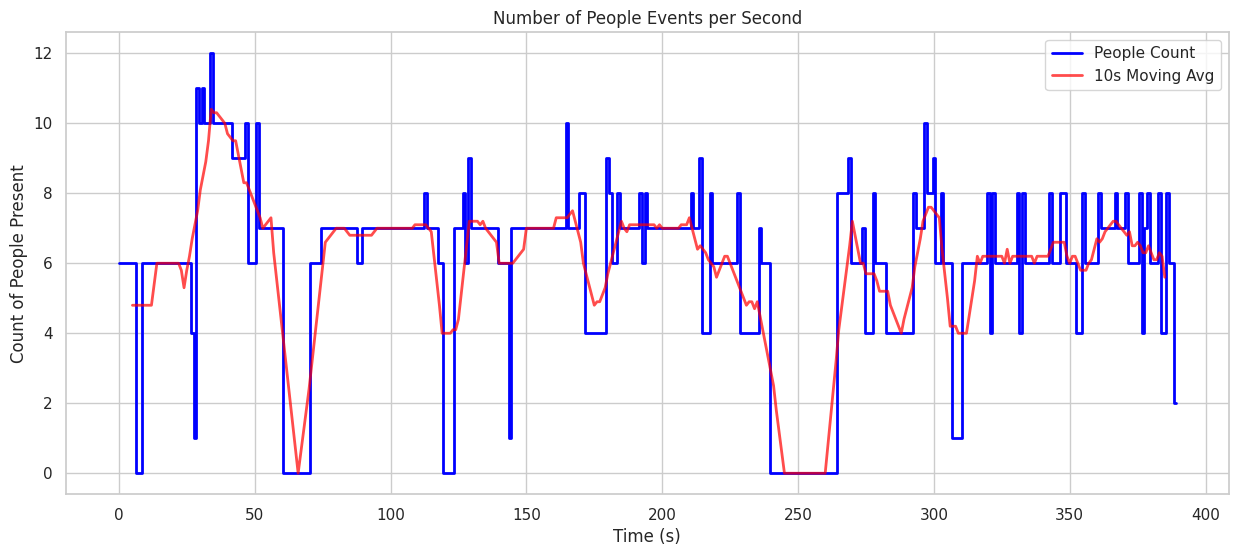

Summary stats:
Peak number of people events: 12.0
Average number of people per second: 5.84
Total duration with people present: 349 seconds


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def people_time_series(video_data, total_duration=None, bin_size=1.0):
    # Collect all people-related events
    people_keywords = set(CATEGORY_MAP["people"])
    people_dfs = [df for name, df in video_data.items() if name.lower() in people_keywords]

    if not people_dfs:
        print("No people annotations found.")
        return None, None

    # Estimate total duration
    if total_duration is None:
        total_duration = max(df['offset'].max() for df in people_dfs)

    bins = np.arange(0, total_duration + bin_size, bin_size)
    counts = np.zeros(len(bins)-1)

    # Count overlaps in each bin
    for df in people_dfs:
        for _, row in df.iterrows():
            start_bin = int(row['onset'] // bin_size)
            end_bin = int(row['offset'] // bin_size)
            counts[start_bin:end_bin+1] += 1

    return bins[:-1], counts

# ---- RUN ----
time_bins, people_counts = people_time_series(video_data, bin_size=1.0)

if people_counts is not None:
    plt.figure(figsize=(15,6))
    # Use step plot for discrete counts
    plt.step(time_bins, people_counts, where="mid", color="blue", lw=2, label="People Count")
    # Optionally smooth for trend
    smooth_counts = pd.Series(people_counts).rolling(window=10, center=True).mean()
    plt.plot(time_bins, smooth_counts, color="red", lw=2, alpha=0.7, label="10s Moving Avg")

    plt.title("Number of People Events per Second")
    plt.xlabel("Time (s)")
    plt.ylabel("Count of People Present")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Summary stats:")
    print(f"Peak number of people events: {people_counts.max()}")
    print(f"Average number of people per second: {people_counts.mean():.2f}")
    print(f"Total duration with people present: {(people_counts>0).sum()} seconds")


In [2]:
import pandas as pd
file = "/ssd_scratch/cvit/kolubex/neuroinformatics/ds003688-download/participants.tsv"

def load_tsv(file_path):
    """Load a TSV file into a pandas DataFrame"""
    return pd.read_csv(file_path, sep='\t')
participants_df = load_tsv(file)
# participant_id	sex	age	handedness	language_dominance	language_dominance_technique	iEEG	fMRI	iEEG_hemisphere	high_density_grid
# sub-01	M	55	R	n/a	n/a	yes	no	LR	no
# filter participants with iEEG data
ieeg_participants = participants_df[participants_df['iEEG'] == 'yes']


In [3]:
ieeg_participants

,participant_id,sex,age,handedness,language_dominance,language_dominance_technique,iEEG,fMRI,iEEG_hemisphere,high_density_grid
0,sub-01,M,55,R,NaN,NaN,yes,no,LR,no
1,sub-02,F,9,R,L,fTCD + fMRI,yes,no,L,no
2,sub-03,F,33,R,L,Wada,yes,no,L,no
4,sub-05,F,33,R,L,fTCD,yes,no,L,no
5,sub-06,F,43,R,L,fMRI,yes,no,L,no
6,sub-07,F,42,R,L,fMRI,yes,yes,L,no
8,sub-09,F,33,R,L,fTCD,yes,yes,L,no
9,sub-10,M,8,R,L,Wada,yes,no,L,no
11,sub-12,M,37,R,L,ECS,yes,no,L,no
12,sub-13,F,17,L,R,Wada,yes,yes,R,no


In [ ]:
import mne

# -----------------------------
# Step 1: Point to your .vhdr file
# -----------------------------
vhdr_file = "/ssd_scratch/cvit/kolubex/neuroinformatics/ds003688-download/sub-14/ses-iemu/ieeg/sub-14_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr"

# -----------------------------
# Step 2: Load raw EEG data
# -----------------------------
raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)

# -----------------------------
# Step 3: Basic preprocessing (optional but recommended)
# -----------------------------
# Set EEG reference (average or mastoids if you know them)
# raw.set_eeg_reference('average', projection=True)

# # Apply bandpass filter (for visualization)
# raw.filter(1., 40., fir_design='firwin')

# # -----------------------------
# # Step 4: Butterfly plot
# # -----------------------------
# raw.plot(duration=10, n_channels=len(raw.ch_names), butterfly=True, scalings='auto')

# # -----------------------------
# # Step 5: (Optional) Event loading
# # -----------------------------
# # If you want to load events from the .vmrk file:
# events, event_id = mne.events_from_annotations(raw)
# mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)

# give plot per electrode
# -----------------------------
# Step 6: Plot individual channel data
# -----------------------------


: 

In [11]:
import numpy as np

# Take one channel (first one for example)
ch_name = raw.ch_names[0]
data, times = raw[ch_name, :]  # data is in Volts

# Compute an appropriate scale (e.g., max abs amplitude)
max_val = np.max(np.abs(data))

# Use ~20% margin so it doesn’t clip
scaling_val = max_val * 1


raw.plot(
    picks=[ch_name],
    n_channels=1,
    title=f'Channel: {ch_name}',
    scalings={'eeg': scaling_val, }
)


KeyboardInterrupt: 

In [ ]:
raw.info

KeyboardInterrupt: 

: 